# 学习率衰减
对于基于一阶梯度进行优化的方法而言，开始的时候更新的幅度是比较大的，也就是说开始的学习率可以设置大一点，但是当训练集的 loss 下降到一定程度之后，使用这个太大的学习率就会导致 loss 一直来回震荡

这个时候就需要对学习率进行衰减已达到 loss 的充分下降，而是用学习率衰减的办法能够解决这个矛盾，学习率衰减就是随着训练的进行不断的减小学习率。

在`tensorflow`中学习率衰减非常方便，使用 `tf.train.exponential_decay`, 但是它只支持指数式衰减和固定步长衰减, 不是很方便
我们使用`placeholder`来实现学习率衰减会更加灵活

In [1]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

import tensorflow as tf
import tensorflow.contrib.slim as slim

from utils import cifar10_input
from utils import resnet

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


在这里, 我们用函数设计一个下降策略:
- 当训练步数小于12000时, 输出0.01
- 大于12000时输出0.001

In [2]:
def lr_step(step, **kwargs):
    lr = tf.cond(tf.less(step, 12000), lambda: 0.1, lambda: 0.01)
    
    return lr

In [4]:
# 导入数据
train_imgs, train_labels, val_imgs, val_labels = cifar10_input.load_data(image_size=96)

In [5]:
is_training = tf.placeholder(tf.bool, name='is_training')    

In [6]:
with slim.arg_scope(resnet.resnet_arg_scope()):
    train_out = resnet.resnet(train_imgs, 10, is_training=is_training)
    val_out = resnet.resnet(val_imgs, 10, is_training=is_training, reuse=True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [7]:
with tf.variable_scope('loss'):
    train_loss = tf.losses.sparse_softmax_cross_entropy(labels=train_labels, logits=train_out, scope='train')
    val_loss = tf.losses.sparse_softmax_cross_entropy(labels=val_labels, logits=val_out, scope='val')

In [8]:
with tf.name_scope('accuracy'):
    with tf.name_scope('train'):
        train_acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(train_out, axis=-1, output_type=tf.int32), train_labels), tf.float32))
    with tf.name_scope('val'):
        val_acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(val_out, axis=-1, output_type=tf.int32), val_labels), tf.float32))

在这里我们用一个占位符来表示学习率, 方便在训练过程中我们从外部修改它

In [9]:
train_step = tf.Variable(0, trainable=False, name='train_step')
lr = lr_step(train_step)

opt = tf.train.MomentumOptimizer(lr, momentum=0.9)

In [10]:
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_op = opt.minimize(train_loss, global_step=train_step)

In [11]:
from utils.learning import train_with_bn

In [14]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_losses, train_accs, val_losses, val_accs = \
    train_with_bn(sess, train_op, train_loss, train_acc, val_loss, val_acc, 20000, is_training=is_training, \
                 train_log_step=200, val_log_step=200)
    
sess.close()

[train]: step 0 loss = 2.4259 acc = 0.1094 (0.0916 / batch)
[val]: step 0 loss = 2.4605 acc = 0.1250
[train]: step 200 loss = 406.4805 acc = 0.0156 (0.0960 / batch)
[val]: step 200 loss = 610.1675 acc = 0.0938
[train]: step 400 loss = 8.1461 acc = 0.1250 (0.0910 / batch)
[val]: step 400 loss = 6.4340 acc = 0.1094
[train]: step 600 loss = 4.2480 acc = 0.1406 (0.0910 / batch)
[val]: step 600 loss = 3.4661 acc = 0.2188
[train]: step 800 loss = 2.9387 acc = 0.2344 (0.0860 / batch)
[val]: step 800 loss = 3.1387 acc = 0.2031
[train]: step 1000 loss = 2.6840 acc = 0.1406 (0.0869 / batch)
[val]: step 1000 loss = 2.6694 acc = 0.2344
[train]: step 1200 loss = 1.9566 acc = 0.3125 (0.0889 / batch)
[val]: step 1200 loss = 2.2255 acc = 0.2500
[train]: step 1400 loss = 4.1973 acc = 0.1094 (0.0895 / batch)
[val]: step 1400 loss = 3.6811 acc = 0.1875
[train]: step 1600 loss = 2.8536 acc = 0.2969 (0.0867 / batch)
[val]: step 1600 loss = 2.6531 acc = 0.3594
[train]: step 1800 loss = 1.7539 acc = 0.5000 (

[train]: step 15400 loss = 0.0132 acc = 1.0000 (0.0849 / batch)
[val]: step 15400 loss = 0.2961 acc = 0.8750
[train]: step 15600 loss = 0.0268 acc = 1.0000 (0.0854 / batch)
[val]: step 15600 loss = 0.6672 acc = 0.7656
[train]: step 15800 loss = 0.0106 acc = 1.0000 (0.0852 / batch)
[val]: step 15800 loss = 0.7615 acc = 0.8594
[train]: step 16000 loss = 0.0145 acc = 1.0000 (0.0850 / batch)
[val]: step 16000 loss = 0.8127 acc = 0.8281
[train]: step 16200 loss = 0.0107 acc = 1.0000 (0.0849 / batch)
[val]: step 16200 loss = 0.7371 acc = 0.8125
[train]: step 16400 loss = 0.0246 acc = 1.0000 (0.0848 / batch)
[val]: step 16400 loss = 0.9524 acc = 0.8125
[train]: step 16600 loss = 0.0271 acc = 0.9844 (0.0847 / batch)
[val]: step 16600 loss = 1.1770 acc = 0.7344
[train]: step 16800 loss = 0.0096 acc = 1.0000 (0.0848 / batch)
[val]: step 16800 loss = 1.0740 acc = 0.6875
[train]: step 17000 loss = 0.0067 acc = 1.0000 (0.0849 / batch)
[val]: step 17000 loss = 1.3294 acc = 0.7969
[train]: step 17200

In [13]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

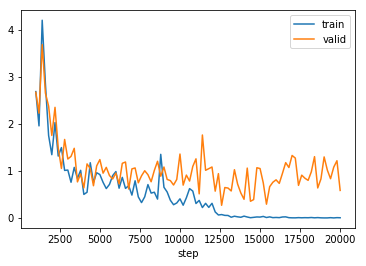

In [15]:
x_axis = np.arange(5, 101) * 200
plt.plot(x_axis, train_losses[5:], label='train')
plt.plot(x_axis, val_losses[5:], label='valid')
plt.xlabel('step')
plt.legend(loc='best')

这里我们训练了`20000`次，在`12000`次的时候进行了学习率衰减，可以看 loss 曲线在 20 次的时候不管是 train loss 还是 valid loss，都有了一个陡降。

当然这里我们只是作为举例，在实际应用中，做学习率衰减之前应该经过充分的训练，比如训练 80 个`epoch`或者 100 个`epoch`，然后再做学习率衰减得到更好的结果，有的时候甚至需要做多次学习率衰减